In [ ]:
#| default_exp key_driver_analysis

In [ ]:
#| include: false
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| include: false
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !wget -P /tmp https://raw.githubusercontent.com/amaiya/causalnlp/main/nbs/sample_data/houses.csv
    !wget -P /tmp https://raw.githubusercontent.com/amaiya/causalnlp/main/nbs/sample_data/adult-census.csv
    !pip install -q causalnlp

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt


from causalnlp.preprocessing import DataframePreprocessor



class KeyDriverAnalysis:
    """
    Performs key driver analysis
    """
    def __init__(self, df, outcome_col='outcome', text_col=None, include_cols=[], ignore_cols=[],
                 verbose=1):
        """
        Instantiates the KeyDriverAnalysis instance.
        """
        self.v = verbose
        self.pp = None # set with call to _preprocess
        self.df, self.x, self.y = self._preprocess(df, outcome_col=outcome_col, text_col=text_col, 
                                                   include_cols=include_cols, ignore_cols=ignore_cols)
        

    def _preprocess(self, df, outcome_col='outcome', text_col=None, include_cols=[], ignore_cols=[]):
        """
        preprocesses DataFrame
        """
        temp_treatment = 'CausalNLP_temp_treatment'
        df = df.copy()
        df[temp_treatment] = [0] * df.shape[0]
        
        # preprocess
        self.pp = DataframePreprocessor(treatment_col = temp_treatment,
                                       outcome_col = outcome_col,
                                       text_col=text_col,
                                       include_cols=include_cols,
                                       ignore_cols=ignore_cols,
                                       verbose=self.v)
        df, x, y, _ = self.pp.preprocess(df,
                                         training=True,
                                         min_df=0.05,
                                         max_df=0.5,
                                         ngram_range=(1,1),
                                         stop_words='english')
        return df, x, y

    def correlations(self, outcome_only=True):
        """
        Computes corelations between independent variables and outcome
        """

        df = self.x.copy()
        df[self.pp.outcome_col] = self.y
        corrALL = df.apply(pd.to_numeric, errors='coerce').corr()
        if outcome_only:
            df_results = corrALL[[self.pp.outcome_col]]
            df_results = df_results.sort_values(by=self.pp.outcome_col, key=abs, ascending=False)
            return df_results.iloc[1: , :]

            #return df_results.sort_values(by=[self.pp.outcome_col])
        else:
            return corrALL

        
        
    def importances(self, plot=True, split_pct=0.2, 
                    use_shap=False, shap_background_size=50,
                    rf_model=None, n_estimators=100, n_jobs=-1, random_state=42):
        """
        Identifies important predictors using a RandomForest model.
        """
       
        X_train, X_test, y_train, y_test = train_test_split(self.x.values, self.y.values, 
                                                            test_size=split_pct, 
                                                            random_state=random_state)
        rf_type = RandomForestClassifier if self.pp.is_classification else RandomForestRegressor
        rf = rf_type(n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   oob_score = True,
                                   bootstrap = True,
                                   random_state = random_state)
        rf.fit(X_train, y_train)
        if self.v:
            print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
                                                                             rf.score(X_train, y_train), 
                                                                             rf.oob_score_,
                                                                             rf.score(X_test, y_test)))
        driverNames = self.x.columns.values
        if use_shap:
            try:
                import shap
            except ImportError:
                raise ImportError('Please install shap (conda recommended): '+\
                                 'conda install shap --channel conda-forge')
            explainer = shap.KernelExplainer(rf.predict, X_test[:shap_background_size,:])
            shap_values = explainer.shap_values(X_test[:shap_background_size,:])
            if plot:
                shap.summary_plot(shap_values, X_test[:shap_background_size,:], feature_names=driverNames)
            vals = np.abs(shap_values).mean(0)

            df_results = pd.DataFrame(list(zip(driverNames, vals)),
                                  columns=['Driver','Importance'])
            df_results.sort_values(by=['Importance'],
                                   ascending=False, inplace=True)
            return df_results
        else:
            df_results = pd.DataFrame(data = {'Driver': driverNames,
                                             'Importance': rf.feature_importances_})
            df_results = df_results.sort_values('Importance', ascending=False)
            if plot:
                feat_importances = pd.Series(rf.feature_importances_, index=driverNames)
                feat_importances.nlargest(20).plot(kind='barh')
            return df_results        

In [ ]:
show_doc(KeyDriverAnalysis.correlations)

<h4 id="KeyDriverAnalysis.correlations" class="doc_header"><code>KeyDriverAnalysis.correlations</code><a href="__main__.py#L54" class="source_link" style="float:right">[source]</a></h4>

> <code>KeyDriverAnalysis.correlations</code>(**`outcome_only`**=*`True`*)

Computes corelations between independent variables and outcome

In [ ]:
import pandas as pd
from causalnlp.key_driver_analysis import KeyDriverAnalysis

In [ ]:
df = pd.read_csv('sample_data/houses.csv')

In [ ]:
kda = KeyDriverAnalysis(df, outcome_col='SalePrice', ignore_cols=['Id', 'YearSold'])

outcome column (numerical): SalePrice
treatment column: CausalNLP_temp_treatment
numerical/categorical covariates: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',

In [ ]:
df_results = kda.correlations()
df_results.head()

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581


In [ ]:
assert df_results.iloc[[0]].index.values[0] == 'OverallQual'

In [ ]:
show_doc(KeyDriverAnalysis.importances)

<h4 id="KeyDriverAnalysis.importances" class="doc_header"><code>KeyDriverAnalysis.importances</code><a href="https://github.com/amaiya/causalnlp/tree/main/causalnlp/key_driver_analysis.py#L77" class="source_link" style="float:right">[source]</a></h4>

> <code>KeyDriverAnalysis.importances</code>(**`plot`**=*`True`*, **`split_pct`**=*`0.2`*, **`use_shap`**=*`False`*, **`shap_background_size`**=*`50`*, **`rf_model`**=*`None`*, **`n_estimators`**=*`100`*, **`n_jobs`**=*`-1`*, **`random_state`**=*`42`*)

Identifies important predictors using a RandomForest model.

#### Example: Variable Importances for Housing Prices

R^2 Training Score: 0.98 
OOB Score: 0.85 
R^2 Validation Score: 0.89


,Driver,Importance
3,OverallQual,0.557707
15,GrLivArea,0.121145
11,TotalBsmtSF,0.035977
13,2ndFlrSF,0.033758
8,BsmtFinSF1,0.028563


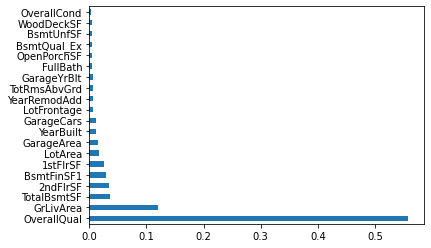

In [ ]:
df_results = kda.importances()
df_results.head()

#### Example: Variable Importances for Probability of Making Over $50K

In [ ]:
#| notest
import pandas as pd

replaced ['<=50K', '>50K'] in column "class" with [0, 1]
outcome column (categorical): class
treatment column: CausalNLP_temp_treatment
numerical/categorical covariates: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
preprocess time:  0.5094420909881592  sec
R^2 Training Score: 0.98 
OOB Score: 0.85 
R^2 Validation Score: 0.85


  0%|          | 0/50 [00:00<?, ?it/s]

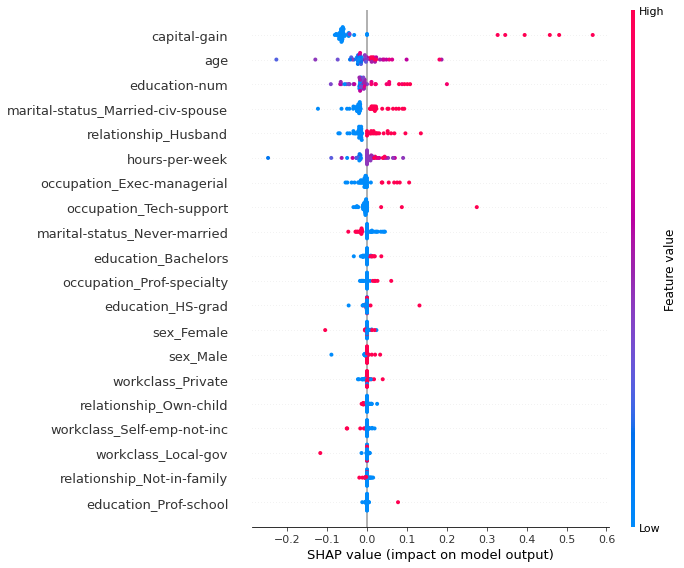

,Driver,Importance
2,capital-gain,0.102854
0,age,0.036508
1,education-num,0.035481
32,marital-status_Married-civ-spouse,0.031246
52,relationship_Husband,0.028451


In [ ]:
#| notest
df = pd.read_csv('sample_data/adult-census.csv')
kda = KeyDriverAnalysis(df, outcome_col='class', ignore_cols=['fnlwgt'])
df_results = kda.importances(use_shap=True, plot=True)
df_results.head()